# Machine Learning Model: Which region is ideal for the development of new oil wells?

As an analyst for the OilyGiant mining company, we need to identify the region that is ideal for a new well.

In this project we will attempt to train models to predict the volume of reserves in the new wells identified in each region. We have data for existing oil wells in these regions.

Only linear regression is suitable for model training since the remaining models are not sufficiently predictable.

When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation. The budget for development of 200 oil wells is 100 USD million. One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels). After the risk evaluation, only the regions with the risk of losses lower than 2.5% are to be retained. From the ones that fit the criteria, the region with the highest average profit will be selected. 

The project will proceed in three stages.

1. We will process the data and perform some exploratory data analysis.

2. We will split the data into training and validation and sets in a 3:1 ratio. We will then train linear regression models on the training sets for the three regions and identify the best model for each and calculate the RMSE values.

3. We will calculate the volume of reserves sufficient for developing a new well without losses and compare this with the average volume of reserves in each region.

4. We will pick the wells with highest values of predictions and calculate the profit for the obtained volume of reserves. We will then use the bootstrapping technique with a 1000 samples to find the profit distribution.

This should allow us to identify a region for further development.


In [1]:
#importing required libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import randint
import seaborn as sns
from matplotlib import pyplot as plt
import plotly as py
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState

In [24]:
#declaring global variables
well_num = 200 #number of wells to develop for profit calculations
dev_cost = 100000000 #cost of developing 200 wells in USD
rev_per_thou = 4500 #revenue per 1000 barrels which is are the units in for the target value (product)
mill = 1000000

In [3]:
#loading the data and examining it
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_0.info()
display(geo_data_0.head())
geo_data_1.info()
display(geo_data_1.head())
geo_data_2.info()
display(geo_data_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#duplications detection
print(geo_data_0.duplicated().sum())
print(geo_data_0['id'].duplicated().sum())
print(geo_data_0.loc[geo_data_0['id'].duplicated(keep=False)])
print(geo_data_1.duplicated().sum())
print(geo_data_1['id'].duplicated().sum())
print(geo_data_1.loc[geo_data_1['id'].duplicated(keep=False)])
print(geo_data_2.duplicated().sum())
print(geo_data_2['id'].duplicated().sum())
print(geo_data_2.loc[geo_data_2['id'].duplicated(keep=False)])

0
10
          id        f0        f1         f2     product
931    HZww2  0.755284  0.368511   1.863211   30.681774
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
64022  74z30  0.741456  0.459229   5.153109  140.771492
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
89582  bsk9y  0.398908 -0.400253  10.122376

There are no null values in the 100000 entries in each dataset for the individual regions. And the data is classified correctly.
Duplicates were identified for well id in each data set but on careful examination, we observe that the features and volumes are unique and this likely represent adjacent wells or sub-wells. Since the features are used to develop models, we should treat them as independent wells.

## Exploratory Data Analysis

Let us examine the distribution of volume of reserves in each region. With the limited data descriptions available, further analysis is beyond the scope of the available data.

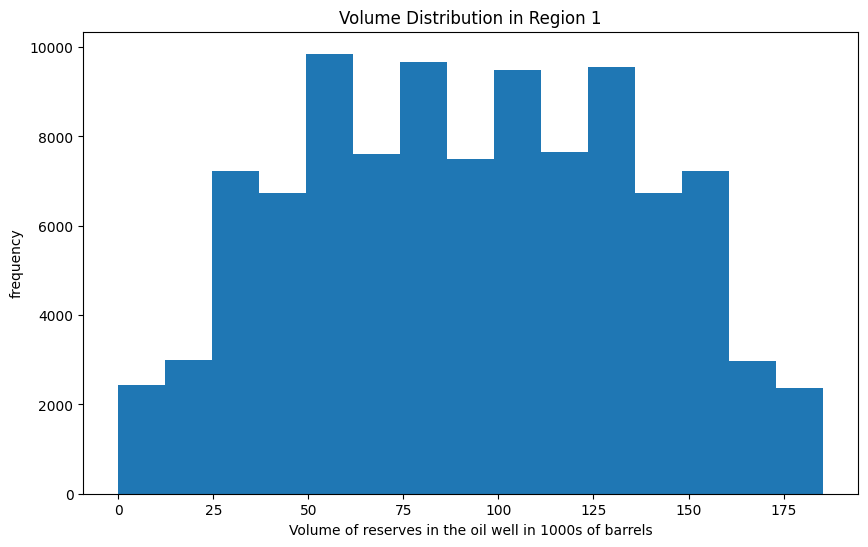

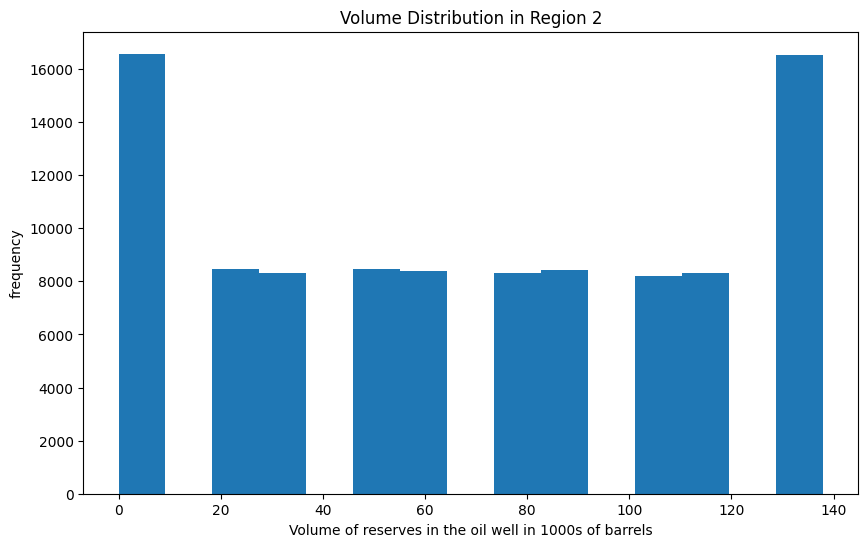

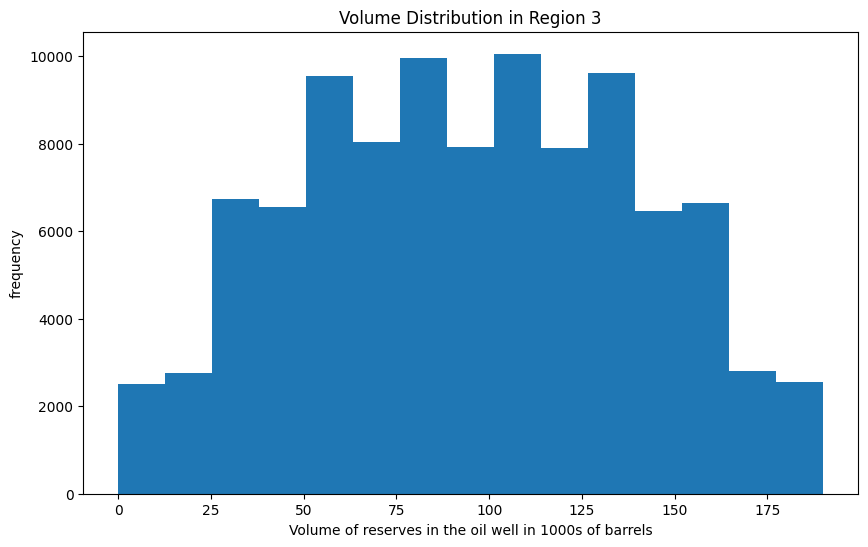

In [5]:
#plotting distribution of product in each region
geo_data_0['product'].plot(kind='hist', figsize=(10,6),bins=15,title='Volume Distribution in Region 1')
plt.xlabel('Volume of reserves in the oil well in 1000s of barrels')
plt.ylabel('frequency')
plt.show()
geo_data_1['product'].plot(kind='hist', figsize=(10,6),bins=15,title='Volume Distribution in Region 2')
plt.xlabel('Volume of reserves in the oil well in 1000s of barrels')
plt.ylabel('frequency')
plt.show()
geo_data_2['product'].plot(kind='hist', figsize=(10,6),bins=15,title='Volume Distribution in Region 3')
plt.xlabel('Volume of reserves in the oil well in 1000s of barrels')
plt.ylabel('frequency')
plt.show()

Regions 1 and three show very similiar distributions of reserves in the wells, close to a gaussian distribution with the wells almost symetrically distributed around the mean. Region 2, however, shows an almost inverse distribution with a lot of wells having very low reserves or very high reserves and the remaining reserves evenly distributed across the range in between the extremes.

# Training the Models

We do not need to encode the features columns, since they are already floats and appear to be on the same scale. We will proceed by dropping the non contributing columns in each data set and developing the model. Also considering the distribution of the reserves we saw earlier, it does not seem like a weight adjustment is needed here for the target values when training the model. In all three regions the well reserve distribution is fairly continuous and symmetric around the mean, whether the shape of the distribution is peaking at the mean or not.

In [28]:
#dropping non-contributing columns and target to get features set
geo_data_0features = geo_data_0.drop(columns=['id','product'],axis=1)
geo_data_1features = geo_data_1.drop(columns=['id','product'],axis=1)
geo_data_2features = geo_data_2.drop(columns=['id','product'],axis=1)
#defining target for each set
geo_data_0target = geo_data_0['product']
geo_data_1target = geo_data_1['product']
geo_data_2target = geo_data_2['product']
#function to train linear regression model for each region and calculate parameters
def regression_metrics(features,target,name):
    features_train,features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345) #splitting the dat into training and validation sets in the 75:25 ratio specified
    model = LinearRegression() #specifiying the model
    model.fit(features_train,target_train)#training on the training set
    pred = model.predict(features_valid) #predicting with the validation set
    rmse = (mean_squared_error(target_valid, pred))**0.5 #calculating rmse
    r2 = r2_score(target_valid, pred) #calculating r2
    n = len(target_valid) #declaring new variable for length of validation set
    p = 3  #declaring new variable for number of features
    adj_r2 = 1 - ((1 - r2_score(target_valid, pred)) * (n - 1) / (n - p - 1)) #calculating adjusted r2
    mae = mean_absolute_error(target_valid, pred) #calculating mean absolute error
    average_reserve = target.mean() #calculating the average actual reserves
    median_reserve = target.median() #calculating the median actual reserves
    print(f"RMSE of the linear regression model developed for {name} is {rmse:0.2f}")
    print(f"R2 for {name} = {r2:0.6f}")
    print(f"Adjusted R-squared for {name}: {adj_r2:0.6f}")
    print(f"Mean Absolute Error (MAE) for {name}: {mae:0.2f}")
    print(f"Average reserve in {name} is:{average_reserve:0.2f} (1000 barrels)")
    print(f"Median reserve in {name} is:{median_reserve:0.2f} (1000 barrels)")
    pred_s = pd.Series(pred, index=target_valid.index)
    return pred_s,features_train,features_valid, target_train, target_valid
#calling the function to train the model for each region
pred0, df0features_train, df0features_valid, df0target_train, df0target_valid = regression_metrics(geo_data_0features,geo_data_0target,"region 0")
pred1, df1features_train, df1features_valid, df1target_train, df1target_valid = regression_metrics(geo_data_1features,geo_data_1target,"region 1")
pred2, df2features_train, df2features_valid, df2target_train, df2target_valid = regression_metrics(geo_data_2features,geo_data_2target,"region 2")

RMSE of the linear regression model developed for region 0 is 37.58
R2 for region 0 = 0.279943
Adjusted R-squared for region 0: 0.279857
Mean Absolute Error (MAE) for region 0: 30.92
Average reserve in region 0 is:92.50 (1000 barrels)
Median reserve in region 0 is:91.85 (1000 barrels)
RMSE of the linear regression model developed for region 1 is 0.89
R2 for region 1 = 0.999623
Adjusted R-squared for region 1: 0.999623
Mean Absolute Error (MAE) for region 1: 0.72
Average reserve in region 1 is:68.83 (1000 barrels)
Median reserve in region 1 is:57.09 (1000 barrels)
RMSE of the linear regression model developed for region 2 is 40.03
R2 for region 2 = 0.205248
Adjusted R-squared for region 2: 0.205152
Mean Absolute Error (MAE) for region 2: 32.79
Average reserve in region 2 is:95.00 (1000 barrels)
Median reserve in region 2 is:94.93 (1000 barrels)


The most predictive model appears to be for region 2. It has the lowest value for rmse, the r2 is close to 1 which means the prediction is close to perfect and mean absolute error is also the lowest (this does not take into account the direction of the error and is less sensitive to outliers compared to rmse and mse). Since this is a simple linea regression, I was interested in determining if one of the features was superfluous leading to the low quality of the models for regions 0 and 2 but from the adjusted R-squared values, that does not seem to be the case. They are identical to the R-squared value without adjustment. It is likely the dependence is not a simple linear regression in this case and another model is likely more appropriate to describe the relationship between features and reserves in these regions. 
In any case, for the profit calculation, it makes sense to proceed with region 2 since the predictions for reserves is the most accurate here, but for thoroughness we may calculate for all the regions.

## Calculating minimum reserves needed to generate a profit
200 oil wells need 100 million USD to develop (let us take this as baseline, minimum of 200 wells need to be developed).
One barrel brings 4.5 USD of revenue and since product is in units of 1000s of barrels each unit of product generates 4.5*1000 or 4500 USD of revenue.
Since tax, operational and other costs are not mentioned separately, we are assuming the 100 million USD for development includes all these costs.
To break even, i.e., not generate any losses, the revenue will need to equal the costs of development, or 100 million USD from 200 wells.

In [29]:
#calculating product to break even
res_breakeven = dev_cost/rev_per_thou
print(f"Reserves needed in 200 wells to break even is:{res_breakeven:.2f} (1000 barrels)")

Reserves needed in 200 wells to break even is:22222.22 (1000 barrels)


In [30]:
#calculating the top 200 wells in each region and their reserves
goe0_top200 = geo_data_0['product'].sort_values(ascending=False).head(200).sum()
print(f"Total reserve in region 0 top 200 wells is:{goe0_top200:.2f} (1000 barrels)")
goe1_top200 = geo_data_1['product'].sort_values(ascending=False).head(200).sum()
print(f"Total reserve in region 0 top 200 wells is:{goe1_top200:.2f} (1000 barrels)")
goe2_top200 = geo_data_2['product'].sort_values(ascending=False).head(200).sum()
print(f"Total reserve in region 0 top 200 wells is:{goe2_top200:.2f} (1000 barrels)")

Total reserve in region 0 top 200 wells is:36966.75 (1000 barrels)
Total reserve in region 0 top 200 wells is:27589.08 (1000 barrels)
Total reserve in region 0 top 200 wells is:37910.30 (1000 barrels)


In [31]:
#calculating average reserves needed per well
av_product = res_breakeven/200
print(f"Average reserve needed per well to break even is:{av_product:.2f} (1000 barrels)")

Average reserve needed per well to break even is:111.11 (1000 barrels)


We see that none of the regions have the average reserves per well when averaged over the 100000 wells in each dataset to break even from the earlier mean and median calculation that was a part of the model function. The median suggests that the distribution may skew towards the lower end of reserves for all three regions.
When we look at the top 200 wells in each region and their product, we see that all of them exceed what is needed to break even but these are the wells with the most reserves and likely not predictive of the overall trend for the region. Since the average reserves are below the average needed to break even, we are likely to incur a loss if we choose 200 wells at random.
This points to the necessity of machine learning combined with bootstrapping to estimate profit distributions.

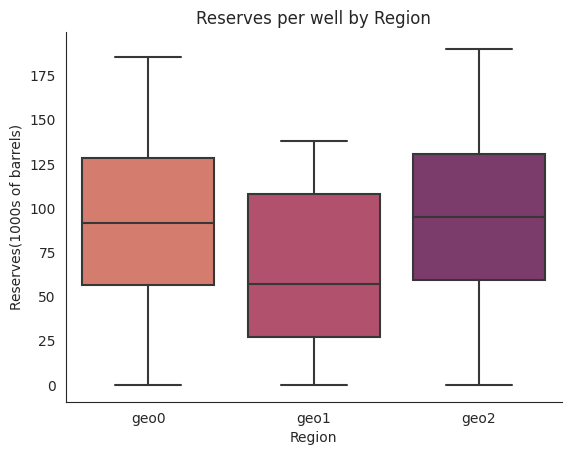

In [32]:
#box plot of the reserve volume distribution in each regio with median side by side
combined_dfs = pd.DataFrame({'geo0': geo_data_0['product'],
                             'geo1': geo_data_1['product'],
                             'geo2': geo_data_2['product']})
sns.set_style('white')
sns.boxplot(data=combined_dfs, palette='flare').set(title='Reserves per well by Region')
plt.xlabel('Region')
plt.ylabel('Reserves(1000s of barrels)')
sns.despine()
plt.show()

## Profit calculation from the wells with the highest predicted reserves:
We select the top 200 wells with highest predicted reserves and calculate profit from these wells.

In [33]:
#calculating the predicted reserves from the top 200 wells to enable comparison later if useful
pgoe0_top200 = pred0.sort_values(ascending=False).head(200)
pgeo_0_total_res = pgoe0_top200.sum()
pgoe1_top200 = pred1.sort_values(ascending=False).head(200)
pgeo_1_total_res = pgoe1_top200.sum()
pgoe2_top200 = pred2.sort_values(ascending=False).head(200)
pgeo_2_total_res = pgoe2_top200.sum()
print(f"Total reserve predicted in region 0 top 200 wells is:{pgeo_0_total_res:.2f} (1000 barrels)")
print(f"Total reserve predicted in region 1 top 200 wells is:{pgeo_1_total_res:.2f} (1000 barrels)")
print(f"Total reserve predicted in region 2 top 200 wells is:{pgeo_2_total_res:.2f} (1000 barrels)")

Total reserve predicted in region 0 top 200 wells is:31102.33 (1000 barrels)
Total reserve predicted in region 1 top 200 wells is:27746.03 (1000 barrels)
Total reserve predicted in region 2 top 200 wells is:29603.90 (1000 barrels)


In [35]:
#Function to calculate profit from top 200 predicted wells using actual values of reserves
def profit(prediction, target, count):
    top_200 = prediction.sort_values(ascending=False).index[:count]
    targ_200 = target.loc[top_200]
    rev_targ = targ_200.sum()*rev_per_thou
    profit = (rev_targ-dev_cost)/mill #profit in millions of USD
    return profit
geo0_prof = profit(pred0,df0target_valid,well_num)
geo1_prof = profit(pred1,df1target_valid,well_num)
geo2_prof = profit(pred2,df2target_valid,well_num)
print(f"Profit from region0:{geo0_prof:.4f} million USD")
print(f"Profit from region1:{geo1_prof:.4f} million USD")
print(f"Profit from region2:{geo2_prof:.4f} million USD")

Profit from region0:33.2083 million USD
Profit from region1:24.1509 million USD
Profit from region2:27.1035 million USD


It appears that the region that generates the highest profit is region 20/geo_data_0 with a profit of 33.2083 million USD based on actual reserves in the top 200 wells predicted by the model. In 2nd place is the region 2/geo_data_2 with a net profit of approximately 27 million USD. This would support the development of region 3 since it appears to generate the hughest net profit.

## Bootstrapping to find the profit distribution


In [43]:
# bootstrapping function
state = RandomState(12345)
def confidence(target,prediction):
    values = []
    for i in range(1000): 
        subsample = target.sample(n=500, replace=True, random_state=state)
        pred_sample = prediction.loc[subsample.index]
        sample_profit = profit(pred_sample,subsample,well_num)
        values.append(sample_profit)
    values = pd.Series(values)
    med = values.quantile(0.5)
    average = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = np.mean(values < 0)*100
    return lower,upper,risk,med,average
g0 = confidence(df0target_valid,pred0)
g1 = confidence(df1target_valid,pred1)
g2 = confidence(df2target_valid,pred2)
print(f"The 95% confidence interval for profits for region 0 lies between:{g0[0]:0.2f} and {g0[1]:0.2f} million USD and the risk is {g0[2]:0.2f} %")
print(f"The average profit for region 0 is:{g0[4]:0.2f} million USD and the median profit is {g0[3]:0.2f} million USD")
print(f"The 95% confidence interval for profits for region 1 lies between:{g1[0]:0.2f} and {g1[1]:0.2f} million USD and the risk is {g1[2]:0.2f} %")
print(f"The average profit for region 1 is:{g1[4]:0.2f} million USD and the median profit is {g1[3]:0.2f} million USD")
print(f"The 95% confidence interval for profits for region 2 lies between:{g2[0]:0.2f} and {g2[1]:0.2f} million USD and the risk is {g2[2]:0.2f} %")
print(f"The average profit for region 2 is:{g2[4]:0.2f} million USD and the median profit is {g2[3]:0.2f} million USD")

The 95% confidence interval for profits for region 0 lies between:0.13 and 12.31 million USD and the risk is 2.00 %
The average profit for region 0 is:6.01 million USD and the median profit is 5.95 million USD
The 95% confidence interval for profits for region 1 lies between:2.06 and 11.91 million USD and the risk is 0.10 %
The average profit for region 1 is:6.64 million USD and the median profit is 6.52 million USD
The 95% confidence interval for profits for region 2 lies between:0.02 and 12.46 million USD and the risk is 2.50 %
The average profit for region 2 is:5.97 million USD and the median profit is 5.80 million USD


The region 0/geo_data_0 has a risk less than 2.5% (real risk 2%) and the 95% confidence interval for profit lies between 0.13 million USD and 12.31 million USD. The region 1/geo_data_1 has the lowest risk at 0.1% and the 95% confidence interval for profit lies between 2.06 million USD and 11.91 million USD. Considering that the maximum profit is only 400,000 dollars less and considering the developing cost of 100 million, the very low risk of 0.1% and minimum profit (based on 95% confidence interval) of 2.6 million euro, I would recommend region 1 as a lower risk investment with assured returns. Region 0 satisfies the threshold of less than 2.5% risk but the lower predictability of the model and the lower limit of the confidence interval for profit which indicates a profit of less than a million for 100 million USD of investment, Region 1 appears to be the better option.

# Conclusion
In this project, we developed models using oil well features from 3 regions to identify the region best suited for further development for the company OilyGiant.
We had datasets from each region that were processed and then an preliminary data analysis was performed to understand the distribution of oil reserves in these regions.
We then proceeded to train the models using linear regression. No other model was deemed sufficiently predictive and therefore only linear regression was used to train models for the three regions.

The model for the region represented by geo_data_1 was the most accurate, while the other 2 had minimal predictive capacity. Adjusted R2 was calculated to see if the loss of accuracy was because the any of the features used for training was superfluous but that was not the case. It is likely that the relationship between the features and the reserves cannot be accurately described by linear regression. Or the features listed have minimum predictive power for the size of the reserve.

We proceeded to calculate the profits based on the top 200 predicted wells, their actual reserves and the cost of development of 200 wells(100 million USD) and the revenue per 1000 barrels.
We can see that there is a huge deviation between the top 200 wells and their actual reserves versus those predicted by the model when we sum up the reserves from the top 200 predicted reserves and the actual reserves in region 0 and region 2. This deviation is minimal in region 1, further confirming the power of the model for region 1. 

After profit calculation, region 0 appeared to generate the highest profit (33 million USD) followed by region 3(27 million USD). At this stage, it appears that it makes the most sense to choose between region 0 or 3 based on the top predicted reserves and their actual volumes.

However, when the 95% confidence interval for profit was calculated for each region, region 0 and 1 emerged as the clear winners, both clearing the 2.5% risk hurdle and calculated average profits of 6 and 6.64 million USD respectively. However, when you look at the upper and lower limits of the confidence level, the region 0 only gives a 0.5 million gain at the upper limit and at the lower limit the 100 million investment clears around 100,000+ USD in profit while for region 2 the lower limit of the confidence interval for profit is 2 million USD. Also the risk is significantly lower at 0.1% compared to 2% for Region 0.
Considering that the development of new oil wells is inherently risky and speculative, considering all the information available:
 - the predictive strength of the model
 - the magnitude of the risk
 - the confidence interval for estimated profit measured by boostrapping and the upper and lower limits of these limits
 - the cost of development and revenue per 1000 barrels
I would recommend that the OilGiant company proceeds to develop region 1 or the region represented by the dataset geo_data_1.
However, if we are hewing strictly to the specified project requests, region 0 is the region that should be developed since it clears the risk threshold of 2.5% and appears to generate the maximum profits according to the predictions of the model for that region.